### OTUS, Курс NLP
#### ДЗ №02: Практика по PyTorch
##### Выполнил: Кирилл Н., ibnkir@yandex.ru, 13.03.2024 г.

__Задание:__

1. Используя PyTorch, создать и обучить регрессионную модель, которая аппроксимирует значение функции 
$$sin(x + 2y) \cdot e^{-(2x + y)^2}$$ на диапазоне значений [-10;10] по х и у.

2. В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.

3. Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно. 

__Результаты:__
- Посчитать метрику Mean Square Error(MSE) на test.
- Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

In [739]:
import numpy as np
import torch
import torch.utils.data as data_utils
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

#### Генерируем исходные данные и разбиваем их на три выборки

In [740]:
# Кол-во наблюдений в исходных данных
DATA_LEN = 20000

# Размеры тренировочной, валидационной и обучающей выборок соответственно
TRAIN_LEN = int(0.7 * DATA_LEN)
VAL_LEN = int(0.15 * DATA_LEN)
TEST_LEN = DATA_LEN - TRAIN_LEN - VAL_LEN

In [741]:
# Исследуемая функция z(x, y)
def func_z(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor: 
    z = torch.sin(x + 2 * y) * torch.exp(-torch.square(2 * x + y))
    return z  

In [742]:
# Генерируем 3 тензора
x = torch.rand(DATA_LEN)
x = x * 20.0 - 10.0

y = torch.rand(DATA_LEN)
y = y * 20.0 - 10.0

z = func_z(x, y)

In [743]:
x.unsqueeze_(1)
y.unsqueeze_(1)
z.unsqueeze_(1);

In [744]:
# Тензор признаков
features = torch.cat([x, y], dim=1)

In [745]:
features_train = features[:TRAIN_LEN]
target_train = z[:TRAIN_LEN]

features_val = features[TRAIN_LEN: TRAIN_LEN + VAL_LEN]
target_val = z[TRAIN_LEN: TRAIN_LEN + VAL_LEN]

features_test = features[-TEST_LEN:]
target_test = z[-TEST_LEN:]

#### Описание модели

In [746]:
INPUT_SIZE = 2
HIDDEN_SIZE_1 = 30
HIDDEN_SIZE_2 = 30
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-3
EPOCHS = 1000
BATCH_SIZE = 1

In [747]:
class MySinNet(torch.nn.Module):
    def __init__(self):
        super(MySinNet, self).__init__()
        self.fc1 = torch.nn.Linear(INPUT_SIZE, HIDDEN_SIZE_1)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2)
        self.act2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(HIDDEN_SIZE_2, OUTPUT_SIZE)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

#### Вспомогательные функции 

In [748]:
# Создание генераторов данных для обучения и валидации
def create_data_loaders(features_train, target_train, features_val, target_val):
    train_dataset = data_utils.TensorDataset(features_train, target_train)
    train_loader = data_utils.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = data_utils.TensorDataset(features_val, target_val)
    val_loader = data_utils.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader

In [749]:
# Функция обучения и валидации
def run_train_val(model, optimizer, criterion, train_loader, val_loader):
    train_loss = []
    val_loss = []
     
    model.train()
    for epoch in tqdm(range(EPOCHS)):
        running_loss = []
        
        for features, target in train_loader:
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            
        train_loss.append(np.mean(running_loss))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f' % (epoch, train_loss[-1]))

        model.eval()
        running_loss = []
        with torch.no_grad():
            for features, target in val_loader:
                output = model(features)
                loss = criterion(output, target)
                running_loss.append(loss.item())
                
        val_loss.append(np.mean(running_loss))
        if epoch % 20 == 0:
            print('EPOCH %d : val_loss: %f' % (epoch, val_loss[-1]))
        
    return train_loss, val_loss

#### Обучение и валидация модели

In [750]:
train_loader, val_loader = create_data_loaders(features_train, target_train, features_val, target_val)

In [751]:
model = MySinNet()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
loss = nn.MSELoss()

In [752]:
train_loss, val_loss = run_train_val(
    model, 
    optimizer=optimizer, 
    criterion=loss, 
    train_loader=train_loader,
    val_loader=val_loader
)

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0 : train_loss: 0.017728
EPOCH 0 : val_loss: 0.015620
EPOCH 20 : train_loss: 0.012126
EPOCH 20 : val_loss: 0.011778
EPOCH 40 : train_loss: 0.011994
EPOCH 40 : val_loss: 0.011418
EPOCH 60 : train_loss: 0.011966
EPOCH 60 : val_loss: 0.011192
EPOCH 80 : train_loss: 0.011149
EPOCH 80 : val_loss: 0.010869
EPOCH 100 : train_loss: 0.010932
EPOCH 100 : val_loss: 0.010456
EPOCH 120 : train_loss: 0.010789
EPOCH 120 : val_loss: 0.010445
EPOCH 140 : train_loss: 0.010775
EPOCH 140 : val_loss: 0.010378
EPOCH 160 : train_loss: 0.010784
EPOCH 160 : val_loss: 0.010229
EPOCH 180 : train_loss: 0.010751
EPOCH 180 : val_loss: 0.010150
EPOCH 200 : train_loss: 0.010744
EPOCH 200 : val_loss: 0.010248
EPOCH 220 : train_loss: 0.008609
EPOCH 220 : val_loss: 0.008694
EPOCH 240 : train_loss: 0.008037
EPOCH 240 : val_loss: 0.008037
EPOCH 260 : train_loss: 0.008035
EPOCH 260 : val_loss: 0.008223
EPOCH 280 : train_loss: 0.007849
EPOCH 280 : val_loss: 0.007648
EPOCH 300 : train_loss: 0.007840
EPOCH 300 : val_los

In [753]:
print(f'Train loss после завершения обучения: {train_loss[-1]:.6f}')
print(f'Validation loss после завершения обучения: {val_loss[-1]:.6f}')

Train loss после завершения обучения: 0.005400
Validation loss после завершения обучения: 0.006258


#### Оценка на тестовой выборке

In [754]:
model.eval()
with torch.no_grad():
    output = model(features_test)

test_loss = loss(output, target_test).item()
print(f'Средний test loss: {test_loss:.6f}')

Средний test loss: 0.005069


#### Построение графика

In [755]:
# Готовим сетку xy
x_grid, y_grid = torch.meshgrid(torch.arange(-10., 11., 2.), torch.arange(-10., 11., 2.), indexing='xy')
z_true_grid = func_z(x_grid, y_grid)

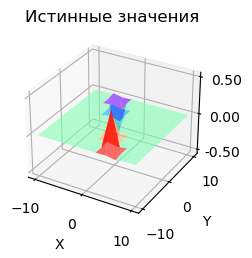

In [756]:
# График с истинными значениями
ax = plt.figure().add_subplot(projection='3d')

ax.plot_surface(
    x_grid.numpy(), 
    y_grid.numpy(), 
    z_true_grid.numpy(),
    alpha=0.6, 
    cmap="rainbow"
)

ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_zlim(z_true_grid.min(), z_true_grid.max())
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title("Истинные значения")
plt.show()

In [757]:
# Меняем размерность данных и делаем инференс модели
x_flat = x_grid.reshape(-1).unsqueeze(1)
y_flat = y_grid.reshape(-1).unsqueeze(1)

xy = torch.cat([x_flat, y_flat], dim=1)

In [758]:
model.eval()
with torch.no_grad():
    z_pred = model(xy)
    
z_pred_grid = z_pred.squeeze(1).reshape((11, 11))

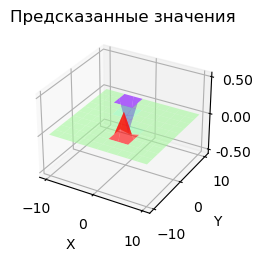

In [759]:
# График с предсказанными значениями
ax = plt.figure().add_subplot(projection='3d')

ax.plot_surface(
    x_grid.numpy(), 
    y_grid.numpy(), 
    z_pred_grid.numpy(),
    alpha=0.6, 
    cmap="rainbow"
)

ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlim(z_true_grid.min(), z_true_grid.max())
plt.title("Предсказанные значения")
plt.show()

__Выводы:__ Наибольшее влияние на точность аппроксимации оказали количество и размер внутренних слоев, а также количество итераций обучения (эпох).